In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

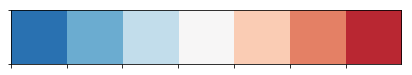

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [6]:
dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv', index_col=0)
print len(dfext)

101976


# Pré-processamento

<h3>Limpeza dos dados</h3>

In [7]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [8]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [9]:
dfcont = dfcont.apply(pd.to_numeric, errors='coerce')  

In [10]:
dfcont.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 1.2 GB


In [11]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,1407984.0,0.936654,2.923291,0.0,0.0,0.000,0.6,100.000
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.200,973.1,1050.000
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.400,973.3,1050.000
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.900,972.8,1050.000
gbrd,5670348.0,1176.371062,1138.753521,0.0,65.0,863.427,2103.0,11586.491
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.400,24.9,44.900
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.100,18.9,42.700
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.900,25.8,45.000
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.600,19.4,44.800
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.800,24.2,45.000


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [12]:
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [13]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [14]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [15]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


<p>A temperatura será inputada pela média</p>

In [16]:
MEAN = ['temp','dewp']

In [17]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())

In [18]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


In [19]:
for v in ['tmax','tmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['temp'])
    df[v] = df[v].fillna(value=df['temp'])
for v in ['dmax','dmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['dewp'])
    df[v] = df[v].fillna(value=df['dewp'])
for v in ['hmax','hmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['hmdy'])
    df[v] = df[v].fillna(value=df['hmdy'])

In [20]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9779168.0,14.727113,5.805794,-10.0,12.1,16.1,18.9,42.7
tmin,9779168.0,21.104973,7.545616,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779168.0,19.864112,7.134923,-8.5,17.2,20.8,24.2,45.0
dmin,9779168.0,14.219949,5.777816,-10.0,11.6,15.6,18.4,44.9


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t. Vamos primeiramente derivá-las para depois verificar quais quando massivamente as variávies estão zeradas, o que pode indicar que a estação falhou.</p>

<p>Utilizando um exemplo especifico de uma estação, depois verificamos o conjunto maior</p> 

In [21]:
dfm = df[(df.wsid==329)]
len(dfm)

87456

In [22]:
dfm.index = pd.to_datetime(dfm.mdct)
dfm.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 00:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 01:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 02:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 03:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
CLEAN = ['wsnm','inme','city','prov','mdct','date']
REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.head(5)  

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 04:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
def derive_nth_hour_feature(df, feature, N):  
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = np.nan
    df.loc[:][col_name] = nth_prior_measurements

In [25]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

for feature in dfm.columns:
    if feature not in NON_DER:
        for h in range(1,6):
            derive_nth_hour_feature(dfm, feature, h) 

In [26]:
REMOVE = [u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [27]:
dfm.columns

Index([u'elvt', u'lat', u'lon', u'prcp', u'stp', u'smax', u'smin', u'temp',
       u'tmax', u'tmin', u'dewp', u'dmax', u'dmin', u'hmdy', u'hmax', u'hmin',
       u'wdsp', u'wdct', u'gust', u'stp_1', u'stp_2', u'stp_3', u'stp_4',
       u'stp_5', u'smax_1', u'smax_2', u'smax_3', u'smax_4', u'smax_5',
       u'smin_1', u'smin_2', u'smin_3', u'smin_4', u'smin_5', u'temp_1',
       u'temp_2', u'temp_3', u'temp_4', u'temp_5', u'tmax_1', u'tmax_2',
       u'tmax_3', u'tmax_4', u'tmax_5', u'tmin_1', u'tmin_2', u'tmin_3',
       u'tmin_4', u'tmin_5', u'dewp_1', u'dewp_2', u'dewp_3', u'dewp_4',
       u'dewp_5', u'dmax_1', u'dmax_2', u'dmax_3', u'dmax_4', u'dmax_5',
       u'dmin_1', u'dmin_2', u'dmin_3', u'dmin_4', u'dmin_5', u'hmdy_1',
       u'hmdy_2', u'hmdy_3', u'hmdy_4', u'hmdy_5', u'hmax_1', u'hmax_2',
       u'hmax_3', u'hmax_4', u'hmax_5', u'hmin_1', u'hmin_2', u'hmin_3',
       u'hmin_4', u'hmin_5', u'wdsp_1', u'wdsp_2', u'wdsp_3', u'wdsp_4',
       u'wdsp_5', u'wdct_1', u'wdct_2', u'

In [28]:
dfm = dfm.reset_index(drop=True)

In [29]:
dfm = dfm.dropna()  

In [30]:
dfm.head(5)

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [32]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
CAN_BE_NULL

['wdsp', 'prcp', 'gust']

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [34]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','wdsp_1','wdsp_2','wdsp_3','wdsp_4','wdsp_5',\
                'gust','gust_1','gust_2','gust_3','gust_4','gust_5']
for v in COLS_BE_NULL:
    cols.remove(v)

In [35]:
dfm[cols] = dfm[cols].replace({0.0:np.nan})
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [36]:
dfm = dfm.dropna()

In [37]:
len(dfm)

86007

In [38]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


In [39]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,86007.0,0.200865,1.632529,0.0,0.0,0.0,0.0,78.4
stp,86007.0,919.116980,3.190611,906.5,916.9,919.0,921.2,931.4
smax,86007.0,919.358709,3.171215,906.7,917.2,919.2,921.5,931.5
smin,86007.0,918.874314,3.199579,906.4,916.7,918.7,921.0,931.2
temp,86007.0,21.897662,3.927088,8.1,19.2,21.6,24.6,37.0
tmax,86007.0,14.566931,3.529708,-6.3,12.2,15.0,17.4,25.5
tmin,86007.0,22.572387,4.097611,8.7,19.7,22.2,25.5,37.7
dewp,86007.0,15.120801,3.520662,-1.7,12.7,15.6,17.9,23.6
dmax,86007.0,21.243377,3.753360,7.4,18.8,21.0,23.8,35.1
dmin,86007.0,14.039955,3.583685,-6.5,11.7,14.5,16.9,21.6


<h3>Balanceamento</h3>

<p>Preparação para o balanceamento</p>

In [40]:
from imblearn.over_sampling import SMOTE

In [ ]:
def f2(x):
    if x['prcp'] == 0.0: 
        return '0 mm'
    else:        
        return 'Maior que 0 mm'    

In [ ]:
dfm['type'] = dfm.apply(f,axis=1)

In [43]:
dfm.head(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5,type
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8,0
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8,0
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3,0


In [44]:
#Criando bins sem chuva(0mm), com poquisima chuva( até 0.1mm), chuva fraca (> 0.1 até 1.0) \
#e depois agrupando de 5 em 
#bins = np.linspace(dfm.prcp.min(), dfm.prcp.max(), 10)
#bins = [0,0.1,1,5,10,15,20,25,30] 
#types = np.digitize(dfm.prcp, bins)  
#dfm['type'] = types

In [45]:
z = dfm['type'].groupby(dfm['type']).count()
print (z)

type
0    80270
1     5737
Name: type, dtype: int64


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [46]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [47]:
#dfm = dfm.drop('prcp',1)

In [48]:
target = 'type'

In [49]:
X = dfm[[col for col in dfm.columns if col != target]]

In [50]:
y = dfm[target]

In [51]:
X.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


<p>Separando o conjunto de treinamento e validação (metade dos 30% separados para validação)</p>

In [52]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=12) 

<p>Executando o balanceamento</p>

In [53]:
from sklearn.decomposition import PCA

In [54]:
pca = PCA(n_components=2)

In [55]:
X_vis = pca.fit_transform(X_train)

In [56]:
kind = ['regular', 'borderline1']
#kind = ['regular', 'borderline1', 'borderline2', 'svm']
sm = [SMOTE(kind=k) for k in kind]
X_resampled = []
y_resampled = []
X_res_vis = []
for method in sm:
    X_res, y_res = method.fit_sample(X, y)
    X_resampled.append(X_res)
    y_resampled.append(y_res)
    X_res_vis.append(pca.transform(X_res))

In [57]:
#X_train_over, y_train_over =  SMOTE(random_state=12).fit_sample(X_train, y_train)

In [58]:
def plot_resampling(ax, X, y, title):
    c0 = ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Sem shuva", alpha=0.5)
    c1 = ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Com chuva", alpha=0.5)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

    return c0, c1

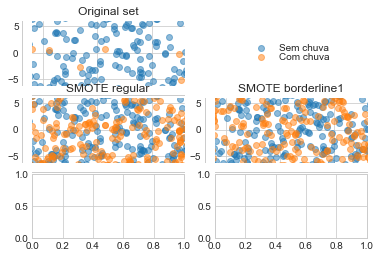

In [59]:
# Two subplots, unpack the axes array immediately
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
# Remove axis for second plot
ax2.axis('off')
ax_res = [ax3, ax4, ax5, ax6]

c0, c1 = plot_resampling(ax1, X_vis, y_train, 'Original set')
for i in range(len(kind)):
    plot_resampling(ax_res[i], X_res_vis[i], y_resampled[i],
                    'SMOTE {}'.format(kind[i]))

ax2.legend((c0, c1), ('Sem chuva', 'Com chuva'), loc='center',
           ncol=1, labelspacing=0.)
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.show()

In [60]:
bkp_x = X_resampled
bkp_y = y_resampled

In [61]:
X_resampled = X_resampled[0]
y_resampled = y_resampled[0]

<p>Reconstruindo o dataframe</p>

In [62]:
#X_train = pd.DataFrame(X_train_over, columns = X_train.columns)
X_train = pd.DataFrame(X_resampled, columns = X_train.columns)

In [63]:
#y_train = pd.DataFrame(y_train_over, columns =['type'])
y_train = pd.DataFrame(y_resampled, columns =['type'])

In [64]:
X_train.head()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
0,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
1,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
2,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
3,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
4,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


In [65]:
#Como o balanceamento SMOTE não serve valores continuos, eu criei classes de chuvas, \
#mas o objetivo ainda persiste em prever o volume de precipitação. Assim vou colocar como alvo a precipitação

<p>Reconstruindo o datafram para alimnar o tensorflow</p>

In [66]:
y_train['prcp'] = X_train['prcp']
y_tmp = X_tmp['prcp']

In [67]:
y_train = y_train.drop('type',1)

In [68]:
X_train = X_train.drop('prcp',1)
X_tmp = X_tmp.drop('prcp',1)

In [69]:
X_tmp.head(3)

,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
65978,919.5,919.8,919.4,19.7,18.0,21.9,18.2,19.6,16.7,90.0,...,146.0,50.0,130.0,122.0,331.0,7.8,2.8,4.4,4.4,2.5
38040,915.7,915.7,915.1,25.7,17.3,26.4,17.5,25.7,17.0,60.0,...,79.0,97.0,81.0,69.0,108.0,5.6,8.4,9.4,8.9,10.0
68328,924.1,924.1,923.4,14.6,13.7,14.9,13.8,14.6,13.6,94.0,...,83.0,105.0,9.0,20.0,31.0,4.5,3.2,1.8,3.3,3.1


<p>Separando o conjunto de testes</p>

In [70]:
target = 'prcp'

In [71]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [72]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   160540, Training features   90
Validation instances 12902, Validation features 90
Testing instances    12901, Testing features    90


In [73]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 500
up = int(len(X_train)/batch_size)

In [74]:
up

321

In [75]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X_train.columns] 

In [76]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[st_units,sd_units],
                                     # activation_fn=activation_fn,
                                      model_dir='/tmp/tf_wx_model-16')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x104bee150>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_wx_model-16', '_save_summary_steps': 100}


In [77]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [78]:
evaluations = []  
STEPS = 500  
for i in range(1, 50):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-49000
INFO:tensorflow:Saving checkpoints for 49001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 7629.3423, step = 49001
INFO:tensorflow:global_step/sec: 20.5887
INFO:tensorflow:loss = 1766.1516, step = 49101 (4.857 sec)
INFO:tensorflow:global_step/sec: 22.69
INFO:tensorflow:loss = 1158.082, step = 49201 (4.407 sec)
INFO:tensorflow:global_step/sec: 22.0763
INFO:tensorflow:loss = 8661.15, step = 49301 (4.529 sec)
INFO:tensorflow:global_step/sec: 21.6462
INFO:tensorflow:loss = 5214.2056, step = 49401 (4.620 sec)
INFO:tensorflow:Saving checkpoints for 49500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 675.9243.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:09:50
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-49500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:09:52
INFO:tensorflow:Saving dict for global step 49500: average_loss = 3.3741007, global_step = 49500, loss = 1674.3326


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-49500
INFO:tensorflow:Saving checkpoints for 49501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9963.617, step = 49501
INFO:tensorflow:global_step/sec: 17.8811
INFO:tensorflow:loss = 8656.607, step = 49601 (5.593 sec)
INFO:tensorflow:global_step/sec: 20.2851
INFO:tensorflow:loss = 447.9802, step = 49701 (4.930 sec)
INFO:tensorflow:global_step/sec: 18.9436
INFO:tensorflow:loss = 9116.035, step = 49801 (5.278 sec)
INFO:tensorflow:global_step/sec: 17.4731
INFO:tensorflow:loss = 8464.023, step = 49901 (5.723 sec)
INFO:tensorflow:Saving checkpoints for 50000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 310.93445.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:10:36


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-50000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:10:38
INFO:tensorflow:Saving dict for global step 50000: average_loss = 3.4733913, global_step = 50000, loss = 1723.6036


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-50000
INFO:tensorflow:Saving checkpoints for 50001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 2985.9946, step = 50001
INFO:tensorflow:global_step/sec: 19.7902
INFO:tensorflow:loss = 306.31848, step = 50101 (5.054 sec)
INFO:tensorflow:global_step/sec: 19.2736
INFO:tensorflow:loss = 7925.422, step = 50201 (5.188 sec)
INFO:tensorflow:global_step/sec: 20.1836
INFO:tensorflow:loss = 826.09796, step = 50301 (4.957 sec)
INFO:tensorflow:global_step/sec: 18.1903
INFO:tensorflow:loss = 2823.3088, step = 50401 (5.496 sec)
INFO:tensorflow:Saving checkpoints for 50500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 9419.135.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:11:19


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-50500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:11:21
INFO:tensorflow:Saving dict for global step 50500: average_loss = 6.6497254, global_step = 50500, loss = 3299.7983


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-50500
INFO:tensorflow:Saving checkpoints for 50501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1600.537, step = 50501
INFO:tensorflow:global_step/sec: 17.5708
INFO:tensorflow:loss = 1836.0857, step = 50601 (5.693 sec)
INFO:tensorflow:global_step/sec: 18.5596
INFO:tensorflow:loss = 12351.111, step = 50701 (5.388 sec)
INFO:tensorflow:global_step/sec: 16.8875
INFO:tensorflow:loss = 2544.074, step = 50801 (5.922 sec)
INFO:tensorflow:global_step/sec: 17.2098
INFO:tensorflow:loss = 873.0558, step = 50901 (5.811 sec)
INFO:tensorflow:Saving checkpoints for 51000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10411.356.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:12:09


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-51000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:12:12
INFO:tensorflow:Saving dict for global step 51000: average_loss = 6.3857627, global_step = 51000, loss = 3168.812


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-51000
INFO:tensorflow:Saving checkpoints for 51001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9931.844, step = 51001
INFO:tensorflow:global_step/sec: 20.2939
INFO:tensorflow:loss = 8086.1416, step = 51101 (4.930 sec)
INFO:tensorflow:global_step/sec: 20.6476
INFO:tensorflow:loss = 765.4691, step = 51201 (4.844 sec)
INFO:tensorflow:global_step/sec: 20.6029
INFO:tensorflow:loss = 9182.656, step = 51301 (4.853 sec)
INFO:tensorflow:global_step/sec: 19.3746
INFO:tensorflow:loss = 10932.643, step = 51401 (5.161 sec)
INFO:tensorflow:Saving checkpoints for 51500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 366.56662.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:12:51
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-51500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:12:53
INFO:tensorflow:Saving dict for global step 51500: average_loss = 3.5214787, global_step = 51500, loss = 1747.4661


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-51500
INFO:tensorflow:Saving checkpoints for 51501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1605.023, step = 51501
INFO:tensorflow:global_step/sec: 18.4773
INFO:tensorflow:loss = 9963.3125, step = 51601 (5.414 sec)
INFO:tensorflow:global_step/sec: 19.2377
INFO:tensorflow:loss = 7160.2734, step = 51701 (5.197 sec)
INFO:tensorflow:global_step/sec: 20.6036
INFO:tensorflow:loss = 3403.3794, step = 51801 (4.854 sec)
INFO:tensorflow:global_step/sec: 19.8187
INFO:tensorflow:loss = 379.51898, step = 51901 (5.046 sec)
INFO:tensorflow:Saving checkpoints for 52000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 6338.9346.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:13:33


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-52000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:13:36
INFO:tensorflow:Saving dict for global step 52000: average_loss = 5.9838433, global_step = 52000, loss = 2969.3672


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-52000
INFO:tensorflow:Saving checkpoints for 52001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 7068.6465, step = 52001
INFO:tensorflow:global_step/sec: 17.7457
INFO:tensorflow:loss = 8372.229, step = 52101 (5.636 sec)
INFO:tensorflow:global_step/sec: 19.2981
INFO:tensorflow:loss = 447.4118, step = 52201 (5.182 sec)
INFO:tensorflow:global_step/sec: 20.3843
INFO:tensorflow:loss = 7592.083, step = 52301 (4.905 sec)
INFO:tensorflow:global_step/sec: 20.5784
INFO:tensorflow:loss = 9843.274, step = 52401 (4.859 sec)
INFO:tensorflow:Saving checkpoints for 52500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1577.0864.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:14:16


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-52500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:14:18
INFO:tensorflow:Saving dict for global step 52500: average_loss = 3.552568, global_step = 52500, loss = 1762.8934


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-52500
INFO:tensorflow:Saving checkpoints for 52501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 520.0586, step = 52501
INFO:tensorflow:global_step/sec: 18.0461
INFO:tensorflow:loss = 296.1395, step = 52601 (5.543 sec)
INFO:tensorflow:global_step/sec: 19.6963
INFO:tensorflow:loss = 10194.484, step = 52701 (5.077 sec)
INFO:tensorflow:global_step/sec: 18.3335
INFO:tensorflow:loss = 5859.486, step = 52801 (5.454 sec)
INFO:tensorflow:global_step/sec: 20.7281
INFO:tensorflow:loss = 1182.0103, step = 52901 (4.825 sec)
INFO:tensorflow:Saving checkpoints for 53000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 6941.942.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:14:58


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-53000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:15:01
INFO:tensorflow:Saving dict for global step 53000: average_loss = 5.7880096, global_step = 53000, loss = 2872.1885


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-53000
INFO:tensorflow:Saving checkpoints for 53001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 10021.18, step = 53001
INFO:tensorflow:global_step/sec: 20.5014
INFO:tensorflow:loss = 4982.763, step = 53101 (4.880 sec)
INFO:tensorflow:global_step/sec: 21.1186
INFO:tensorflow:loss = 991.7749, step = 53201 (4.736 sec)
INFO:tensorflow:global_step/sec: 21.6052
INFO:tensorflow:loss = 774.72894, step = 53301 (4.629 sec)
INFO:tensorflow:global_step/sec: 21.2243
INFO:tensorflow:loss = 10492.837, step = 53401 (4.711 sec)
INFO:tensorflow:Saving checkpoints for 53500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 5084.941.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:15:39
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-53500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:15:42
INFO:tensorflow:Saving dict for global step 53500: average_loss = 3.26767, global_step = 53500, loss = 1621.5183


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-53500
INFO:tensorflow:Saving checkpoints for 53501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 11549.034, step = 53501
INFO:tensorflow:global_step/sec: 20.2189
INFO:tensorflow:loss = 7187.9473, step = 53601 (4.947 sec)
INFO:tensorflow:global_step/sec: 20.7217
INFO:tensorflow:loss = 4263.586, step = 53701 (4.826 sec)
INFO:tensorflow:global_step/sec: 20.6288
INFO:tensorflow:loss = 4860.044, step = 53801 (4.847 sec)
INFO:tensorflow:global_step/sec: 21.1271
INFO:tensorflow:loss = 8882.945, step = 53901 (4.732 sec)
INFO:tensorflow:Saving checkpoints for 54000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 3544.9443.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:16:20


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-54000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:16:25
INFO:tensorflow:Saving dict for global step 54000: average_loss = 3.2725852, global_step = 54000, loss = 1623.9575


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-54000
INFO:tensorflow:Saving checkpoints for 54001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1339.6001, step = 54001
INFO:tensorflow:global_step/sec: 20.6662
INFO:tensorflow:loss = 1104.6123, step = 54101 (4.840 sec)
INFO:tensorflow:global_step/sec: 20.002
INFO:tensorflow:loss = 8433.349, step = 54201 (4.998 sec)
INFO:tensorflow:global_step/sec: 21.1107
INFO:tensorflow:loss = 4894.3477, step = 54301 (4.738 sec)
INFO:tensorflow:global_step/sec: 18.7175
INFO:tensorflow:loss = 457.6386, step = 54401 (5.343 sec)
INFO:tensorflow:Saving checkpoints for 54500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 7851.8267.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:17:04
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-54500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:17:07
INFO:tensorflow:Saving dict for global step 54500: average_loss = 5.927287, global_step = 54500, loss = 2941.3022


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-54500
INFO:tensorflow:Saving checkpoints for 54501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 8817.588, step = 54501
INFO:tensorflow:global_step/sec: 19.3733
INFO:tensorflow:loss = 4078.7524, step = 54601 (5.161 sec)
INFO:tensorflow:global_step/sec: 19.0821
INFO:tensorflow:loss = 820.4787, step = 54701 (5.240 sec)
INFO:tensorflow:global_step/sec: 15.4832
INFO:tensorflow:loss = 5413.1963, step = 54801 (6.459 sec)
INFO:tensorflow:global_step/sec: 16.5405
INFO:tensorflow:loss = 7968.4707, step = 54901 (6.047 sec)
INFO:tensorflow:Saving checkpoints for 55000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 469.1593.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:17:49
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-55000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:17:52
INFO:tensorflow:Saving dict for global step 55000: average_loss = 3.6205597, global_step = 55000, loss = 1796.633


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-55000
INFO:tensorflow:Saving checkpoints for 55001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 506.34958, step = 55001
INFO:tensorflow:global_step/sec: 17.3433
INFO:tensorflow:loss = 10036.405, step = 55101 (5.767 sec)
INFO:tensorflow:global_step/sec: 20.748
INFO:tensorflow:loss = 9048.483, step = 55201 (4.819 sec)
INFO:tensorflow:global_step/sec: 17.8421
INFO:tensorflow:loss = 371.97247, step = 55301 (5.606 sec)
INFO:tensorflow:global_step/sec: 19.6397
INFO:tensorflow:loss = 6984.2075, step = 55401 (5.091 sec)
INFO:tensorflow:Saving checkpoints for 55500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 9019.209.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:18:33


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-55500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:18:35
INFO:tensorflow:Saving dict for global step 55500: average_loss = 6.244699, global_step = 55500, loss = 3098.812


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-55500
INFO:tensorflow:Saving checkpoints for 55501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 2833.2793, step = 55501
INFO:tensorflow:global_step/sec: 12.7478
INFO:tensorflow:loss = 11184.373, step = 55601 (7.845 sec)
INFO:tensorflow:global_step/sec: 7.13169
INFO:tensorflow:loss = 2168.1108, step = 55701 (14.023 sec)
INFO:tensorflow:global_step/sec: 11.5611
INFO:tensorflow:loss = 481.10352, step = 55801 (8.649 sec)
INFO:tensorflow:global_step/sec: 19.8029
INFO:tensorflow:loss = 10237.719, step = 55901 (5.050 sec)
INFO:tensorflow:Saving checkpoints for 56000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 3547.2515.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:19:30
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-56000


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-18-21:19:32
INFO:tensorflow:Saving dict for global step 56000: average_loss = 3.3073802, global_step = 56000, loss = 1641.2239


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-56000
INFO:tensorflow:Saving checkpoints for 56001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9275.753, step = 56001
INFO:tensorflow:global_step/sec: 16.8584
INFO:tensorflow:loss = 632.73566, step = 56101 (5.933 sec)
INFO:tensorflow:global_step/sec: 19.7141
INFO:tensorflow:loss = 2045.1516, step = 56201 (5.073 sec)
INFO:tensorflow:global_step/sec: 19.5184
INFO:tensorflow:loss = 5154.3633, step = 56301 (5.123 sec)
INFO:tensorflow:global_step/sec: 19.7513
INFO:tensorflow:loss = 12173.701, step = 56401 (5.062 sec)
INFO:tensorflow:Saving checkpoints for 56500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 605.477.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:20:18
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-56500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:20:21
INFO:tensorflow:Saving dict for global step 56500: average_loss = 3.2575512, global_step = 56500, loss = 1616.4972


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-56500
INFO:tensorflow:Saving checkpoints for 56501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 308.04193, step = 56501
INFO:tensorflow:global_step/sec: 18.4593
INFO:tensorflow:loss = 7624.7915, step = 56601 (5.417 sec)
INFO:tensorflow:global_step/sec: 20.3286
INFO:tensorflow:loss = 9095.914, step = 56701 (4.919 sec)
INFO:tensorflow:global_step/sec: 20.2717
INFO:tensorflow:loss = 697.06335, step = 56801 (4.934 sec)
INFO:tensorflow:global_step/sec: 19.7579
INFO:tensorflow:loss = 12177.471, step = 56901 (5.061 sec)
INFO:tensorflow:Saving checkpoints for 57000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 6967.3154.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:21:01


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-57000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:21:04
INFO:tensorflow:Saving dict for global step 57000: average_loss = 5.725991, global_step = 57000, loss = 2841.4128


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-57000
INFO:tensorflow:Saving checkpoints for 57001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 4445.035, step = 57001
INFO:tensorflow:global_step/sec: 17.1747
INFO:tensorflow:loss = 361.22766, step = 57101 (5.825 sec)
INFO:tensorflow:global_step/sec: 13.679
INFO:tensorflow:loss = 13623.177, step = 57201 (7.310 sec)
INFO:tensorflow:global_step/sec: 13.1769
INFO:tensorflow:loss = 8380.756, step = 57301 (7.589 sec)
INFO:tensorflow:global_step/sec: 15.4822
INFO:tensorflow:loss = 461.8752, step = 57401 (6.460 sec)
INFO:tensorflow:Saving checkpoints for 57500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 7682.569.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:21:59


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-57500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:22:02
INFO:tensorflow:Saving dict for global step 57500: average_loss = 5.736603, global_step = 57500, loss = 2846.6787


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-57500
INFO:tensorflow:Saving checkpoints for 57501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 7876.425, step = 57501
INFO:tensorflow:global_step/sec: 8.2381
INFO:tensorflow:loss = 687.0084, step = 57601 (12.141 sec)
INFO:tensorflow:global_step/sec: 19.574
INFO:tensorflow:loss = 7372.415, step = 57701 (5.109 sec)
INFO:tensorflow:global_step/sec: 17.4769
INFO:tensorflow:loss = 4848.7812, step = 57801 (5.722 sec)
INFO:tensorflow:global_step/sec: 19.4279
INFO:tensorflow:loss = 766.4785, step = 57901 (5.148 sec)
INFO:tensorflow:Saving checkpoints for 58000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 451.04776.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:23:02
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-58000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:23:04
INFO:tensorflow:Saving dict for global step 58000: average_loss = 3.2297127, global_step = 58000, loss = 1602.6829


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-58000
INFO:tensorflow:Saving checkpoints for 58001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9612.889, step = 58001
INFO:tensorflow:global_step/sec: 17.3993
INFO:tensorflow:loss = 1169.5338, step = 58101 (5.748 sec)
INFO:tensorflow:global_step/sec: 18.8663
INFO:tensorflow:loss = 715.87476, step = 58201 (5.300 sec)
INFO:tensorflow:global_step/sec: 18.0209
INFO:tensorflow:loss = 7614.7705, step = 58301 (5.549 sec)
INFO:tensorflow:global_step/sec: 19.6936
INFO:tensorflow:loss = 11553.262, step = 58401 (5.078 sec)
INFO:tensorflow:Saving checkpoints for 58500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 396.10223.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:23:47


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-58500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:23:50
INFO:tensorflow:Saving dict for global step 58500: average_loss = 3.274938, global_step = 58500, loss = 1625.125


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-58500
INFO:tensorflow:Saving checkpoints for 58501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 2129.6953, step = 58501
INFO:tensorflow:global_step/sec: 18.7261
INFO:tensorflow:loss = 1306.8608, step = 58601 (5.343 sec)
INFO:tensorflow:global_step/sec: 19.6542
INFO:tensorflow:loss = 10327.517, step = 58701 (5.086 sec)
INFO:tensorflow:global_step/sec: 19.516
INFO:tensorflow:loss = 2146.2722, step = 58801 (5.126 sec)
INFO:tensorflow:global_step/sec: 19.128
INFO:tensorflow:loss = 618.3785, step = 58901 (5.226 sec)
INFO:tensorflow:Saving checkpoints for 59000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10893.919.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:24:32


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-59000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:24:34
INFO:tensorflow:Saving dict for global step 59000: average_loss = 6.287301, global_step = 59000, loss = 3119.9521


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-59000
INFO:tensorflow:Saving checkpoints for 59001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 10824.674, step = 59001
INFO:tensorflow:global_step/sec: 19.4662
INFO:tensorflow:loss = 494.4987, step = 59101 (5.140 sec)
INFO:tensorflow:global_step/sec: 19.5206
INFO:tensorflow:loss = 2301.8538, step = 59201 (5.121 sec)
INFO:tensorflow:global_step/sec: 17.5635
INFO:tensorflow:loss = 8877.245, step = 59301 (5.694 sec)
INFO:tensorflow:global_step/sec: 20.0665
INFO:tensorflow:loss = 11928.695, step = 59401 (4.983 sec)
INFO:tensorflow:Saving checkpoints for 59500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 5877.6245.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:25:14
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-59500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:25:16
INFO:tensorflow:Saving dict for global step 59500: average_loss = 3.2501187, global_step = 59500, loss = 1612.8088


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-59500
INFO:tensorflow:Saving checkpoints for 59501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 6783.275, step = 59501
INFO:tensorflow:global_step/sec: 17.7387
INFO:tensorflow:loss = 411.86383, step = 59601 (5.638 sec)
INFO:tensorflow:global_step/sec: 20.3256
INFO:tensorflow:loss = 1172.2106, step = 59701 (4.920 sec)
INFO:tensorflow:global_step/sec: 21.3854
INFO:tensorflow:loss = 6060.7773, step = 59801 (4.676 sec)
INFO:tensorflow:global_step/sec: 21.5109
INFO:tensorflow:loss = 1278.2513, step = 59901 (4.648 sec)
INFO:tensorflow:Saving checkpoints for 60000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2898.4277.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:25:54
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-60000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:25:57
INFO:tensorflow:Saving dict for global step 60000: average_loss = 3.1898816, global_step = 60000, loss = 1582.9174


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-60000
INFO:tensorflow:Saving checkpoints for 60001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 4454.2437, step = 60001
INFO:tensorflow:global_step/sec: 19.9986
INFO:tensorflow:loss = 320.62662, step = 60101 (5.000 sec)
INFO:tensorflow:global_step/sec: 19.814
INFO:tensorflow:loss = 7229.275, step = 60201 (5.048 sec)
INFO:tensorflow:global_step/sec: 20.0982
INFO:tensorflow:loss = 476.66522, step = 60301 (4.974 sec)
INFO:tensorflow:global_step/sec: 19.5721
INFO:tensorflow:loss = 1236.4553, step = 60401 (5.110 sec)
INFO:tensorflow:Saving checkpoints for 60500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 6886.6846.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:26:36
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-60500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:26:39
INFO:tensorflow:Saving dict for global step 60500: average_loss = 5.7084904, global_step = 60500, loss = 2832.7288


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-60500
INFO:tensorflow:Saving checkpoints for 60501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 2126.372, step = 60501
INFO:tensorflow:global_step/sec: 20.2339
INFO:tensorflow:loss = 6646.6875, step = 60601 (4.943 sec)
INFO:tensorflow:global_step/sec: 20.7574
INFO:tensorflow:loss = 699.87683, step = 60701 (4.819 sec)
INFO:tensorflow:global_step/sec: 19.9216
INFO:tensorflow:loss = 569.81824, step = 60801 (5.018 sec)
INFO:tensorflow:global_step/sec: 21.2383
INFO:tensorflow:loss = 8064.132, step = 60901 (4.708 sec)
INFO:tensorflow:Saving checkpoints for 61000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 7330.7534.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:27:17
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-61000


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-18-21:27:20
INFO:tensorflow:Saving dict for global step 61000: average_loss = 5.9954185, global_step = 61000, loss = 2975.111


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-61000
INFO:tensorflow:Saving checkpoints for 61001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 4971.3843, step = 61001
INFO:tensorflow:global_step/sec: 7.90796
INFO:tensorflow:loss = 623.604, step = 61101 (12.648 sec)
INFO:tensorflow:global_step/sec: 12.5953
INFO:tensorflow:loss = 8497.923, step = 61201 (7.938 sec)
INFO:tensorflow:global_step/sec: 16.0025
INFO:tensorflow:loss = 851.0186, step = 61301 (6.249 sec)
INFO:tensorflow:global_step/sec: 19.7484
INFO:tensorflow:loss = 298.6469, step = 61401 (5.064 sec)
INFO:tensorflow:Saving checkpoints for 61500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10314.432.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:28:12


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-61500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:28:14
INFO:tensorflow:Saving dict for global step 61500: average_loss = 6.0899844, global_step = 61500, loss = 3022.0376


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-61500
INFO:tensorflow:Saving checkpoints for 61501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 12472.799, step = 61501
INFO:tensorflow:global_step/sec: 20.8784
INFO:tensorflow:loss = 603.51483, step = 61601 (4.792 sec)
INFO:tensorflow:global_step/sec: 21.4464
INFO:tensorflow:loss = 12171.281, step = 61701 (4.662 sec)
INFO:tensorflow:global_step/sec: 21.8956
INFO:tensorflow:loss = 6011.958, step = 61801 (4.567 sec)
INFO:tensorflow:global_step/sec: 22.0831
INFO:tensorflow:loss = 292.01923, step = 61901 (4.529 sec)
INFO:tensorflow:Saving checkpoints for 62000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 4355.9136.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:28:51
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-62000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:28:54
INFO:tensorflow:Saving dict for global step 62000: average_loss = 3.2287185, global_step = 62000, loss = 1602.1895


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-62000
INFO:tensorflow:Saving checkpoints for 62001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 599.14734, step = 62001
INFO:tensorflow:global_step/sec: 19.5606
INFO:tensorflow:loss = 4419.154, step = 62101 (5.114 sec)
INFO:tensorflow:global_step/sec: 18.3576
INFO:tensorflow:loss = 9727.365, step = 62201 (5.447 sec)
INFO:tensorflow:global_step/sec: 17.0897
INFO:tensorflow:loss = 904.1541, step = 62301 (5.853 sec)
INFO:tensorflow:global_step/sec: 15.3588
INFO:tensorflow:loss = 660.2836, step = 62401 (6.511 sec)
INFO:tensorflow:Saving checkpoints for 62500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 7937.793.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:29:36


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-62500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:29:39
INFO:tensorflow:Saving dict for global step 62500: average_loss = 5.865352, global_step = 62500, loss = 2910.568


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-62500
INFO:tensorflow:Saving checkpoints for 62501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 7351.8184, step = 62501
INFO:tensorflow:global_step/sec: 20.3045
INFO:tensorflow:loss = 1301.1194, step = 62601 (4.927 sec)
INFO:tensorflow:global_step/sec: 20.6397
INFO:tensorflow:loss = 435.71674, step = 62701 (4.845 sec)
INFO:tensorflow:global_step/sec: 21.4756
INFO:tensorflow:loss = 11041.62, step = 62801 (4.656 sec)
INFO:tensorflow:global_step/sec: 21.3109
INFO:tensorflow:loss = 319.62308, step = 62901 (4.693 sec)
INFO:tensorflow:Saving checkpoints for 63000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 689.53064.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:30:17


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-63000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:30:19
INFO:tensorflow:Saving dict for global step 63000: average_loss = 3.1649005, global_step = 63000, loss = 1570.521


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-63000
INFO:tensorflow:Saving checkpoints for 63001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9305.751, step = 63001
INFO:tensorflow:global_step/sec: 20.0991
INFO:tensorflow:loss = 3224.6157, step = 63101 (4.977 sec)
INFO:tensorflow:global_step/sec: 21.0582
INFO:tensorflow:loss = 630.6285, step = 63201 (4.748 sec)
INFO:tensorflow:global_step/sec: 21.1088
INFO:tensorflow:loss = 9767.863, step = 63301 (4.737 sec)
INFO:tensorflow:global_step/sec: 21.3465
INFO:tensorflow:loss = 715.3644, step = 63401 (4.685 sec)
INFO:tensorflow:Saving checkpoints for 63500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 616.66064.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:30:57


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-63500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:30:59
INFO:tensorflow:Saving dict for global step 63500: average_loss = 3.1972768, global_step = 63500, loss = 1586.5872


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-63500
INFO:tensorflow:Saving checkpoints for 63501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 8628.297, step = 63501
INFO:tensorflow:global_step/sec: 19.1712
INFO:tensorflow:loss = 292.40796, step = 63601 (5.218 sec)
INFO:tensorflow:global_step/sec: 20.6751
INFO:tensorflow:loss = 591.02515, step = 63701 (4.837 sec)
INFO:tensorflow:global_step/sec: 20.6113
INFO:tensorflow:loss = 6427.7354, step = 63801 (4.850 sec)
INFO:tensorflow:global_step/sec: 20.6913
INFO:tensorflow:loss = 1131.4647, step = 63901 (4.834 sec)
INFO:tensorflow:Saving checkpoints for 64000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 674.6896.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:31:39


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-64000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:31:41
INFO:tensorflow:Saving dict for global step 64000: average_loss = 3.1883402, global_step = 64000, loss = 1582.1525


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-64000
INFO:tensorflow:Saving checkpoints for 64001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 3662.7725, step = 64001
INFO:tensorflow:global_step/sec: 14.0284
INFO:tensorflow:loss = 1738.234, step = 64101 (7.130 sec)
INFO:tensorflow:global_step/sec: 12.7147
INFO:tensorflow:loss = 7427.7305, step = 64201 (7.863 sec)
INFO:tensorflow:global_step/sec: 13.9337
INFO:tensorflow:loss = 14796.632, step = 64301 (7.177 sec)
INFO:tensorflow:global_step/sec: 13.9053
INFO:tensorflow:loss = 675.09973, step = 64401 (7.193 sec)
INFO:tensorflow:Saving checkpoints for 64500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10702.406.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:32:30


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-64500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:32:32
INFO:tensorflow:Saving dict for global step 64500: average_loss = 5.6393857, global_step = 64500, loss = 2798.4365


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-64500
INFO:tensorflow:Saving checkpoints for 64501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 6903.5483, step = 64501
INFO:tensorflow:global_step/sec: 18.5967
INFO:tensorflow:loss = 393.49304, step = 64601 (5.380 sec)
INFO:tensorflow:global_step/sec: 22.3539
INFO:tensorflow:loss = 2950.0347, step = 64701 (4.473 sec)
INFO:tensorflow:global_step/sec: 18.5403
INFO:tensorflow:loss = 7183.561, step = 64801 (5.393 sec)
INFO:tensorflow:global_step/sec: 19.1575
INFO:tensorflow:loss = 4672.633, step = 64901 (5.221 sec)
INFO:tensorflow:Saving checkpoints for 65000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 921.45386.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:33:13


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-65000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:33:16
INFO:tensorflow:Saving dict for global step 65000: average_loss = 3.1237967, global_step = 65000, loss = 1550.1241


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-65000
INFO:tensorflow:Saving checkpoints for 65001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 6700.643, step = 65001
INFO:tensorflow:global_step/sec: 16.4111
INFO:tensorflow:loss = 385.694, step = 65101 (6.094 sec)
INFO:tensorflow:global_step/sec: 15.8258
INFO:tensorflow:loss = 9408.824, step = 65201 (6.318 sec)
INFO:tensorflow:global_step/sec: 17.4704
INFO:tensorflow:loss = 6904.766, step = 65301 (5.724 sec)
INFO:tensorflow:global_step/sec: 20.8674
INFO:tensorflow:loss = 781.57886, step = 65401 (4.793 sec)
INFO:tensorflow:Saving checkpoints for 65500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 10418.435.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:33:57
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-65500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:34:00
INFO:tensorflow:Saving dict for global step 65500: average_loss = 5.563102, global_step = 65500, loss = 2760.5823


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-65500
INFO:tensorflow:Saving checkpoints for 65501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 5935.677, step = 65501
INFO:tensorflow:global_step/sec: 18.5662
INFO:tensorflow:loss = 1581.7146, step = 65601 (5.389 sec)
INFO:tensorflow:global_step/sec: 18.9096
INFO:tensorflow:loss = 8951.377, step = 65701 (5.287 sec)
INFO:tensorflow:global_step/sec: 19.2339
INFO:tensorflow:loss = 14018.545, step = 65801 (5.199 sec)
INFO:tensorflow:global_step/sec: 18.5831
INFO:tensorflow:loss = 590.3182, step = 65901 (5.382 sec)
INFO:tensorflow:Saving checkpoints for 66000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 13437.625.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:34:40
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-66000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:34:42
INFO:tensorflow:Saving dict for global step 66000: average_loss = 6.467031, global_step = 66000, loss = 3209.1396


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-66000
INFO:tensorflow:Saving checkpoints for 66001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9147.775, step = 66001
INFO:tensorflow:global_step/sec: 20.1058
INFO:tensorflow:loss = 488.25027, step = 66101 (4.976 sec)
INFO:tensorflow:global_step/sec: 21.3074
INFO:tensorflow:loss = 739.02246, step = 66201 (4.693 sec)
INFO:tensorflow:global_step/sec: 20.5916
INFO:tensorflow:loss = 5375.427, step = 66301 (4.855 sec)
INFO:tensorflow:global_step/sec: 20.7649
INFO:tensorflow:loss = 9829.587, step = 66401 (4.816 sec)
INFO:tensorflow:Saving checkpoints for 66500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2604.1157.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:35:21


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-66500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:35:24
INFO:tensorflow:Saving dict for global step 66500: average_loss = 3.1005025, global_step = 66500, loss = 1538.5647


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-66500
INFO:tensorflow:Saving checkpoints for 66501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 996.7167, step = 66501
INFO:tensorflow:global_step/sec: 18.3729
INFO:tensorflow:loss = 313.0526, step = 66601 (5.444 sec)
INFO:tensorflow:global_step/sec: 18.1815
INFO:tensorflow:loss = 7825.028, step = 66701 (5.499 sec)
INFO:tensorflow:global_step/sec: 19.666
INFO:tensorflow:loss = 282.85928, step = 66801 (5.086 sec)
INFO:tensorflow:global_step/sec: 18.2176
INFO:tensorflow:loss = 1606.9904, step = 66901 (5.489 sec)
INFO:tensorflow:Saving checkpoints for 67000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 7414.732.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:36:06


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-67000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:36:08
INFO:tensorflow:Saving dict for global step 67000: average_loss = 5.69921, global_step = 67000, loss = 2828.1235


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-67000
INFO:tensorflow:Saving checkpoints for 67001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 2977.0562, step = 67001
INFO:tensorflow:global_step/sec: 19.5797
INFO:tensorflow:loss = 699.3308, step = 67101 (5.110 sec)
INFO:tensorflow:global_step/sec: 20.5144
INFO:tensorflow:loss = 11542.568, step = 67201 (4.874 sec)
INFO:tensorflow:global_step/sec: 13.49
INFO:tensorflow:loss = 1835.5264, step = 67301 (7.414 sec)
INFO:tensorflow:global_step/sec: 19.6236
INFO:tensorflow:loss = 360.35608, step = 67401 (5.095 sec)
INFO:tensorflow:Saving checkpoints for 67500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 8013.547.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:36:50
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-67500


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Finished evaluation at 2018-02-18-21:36:53
INFO:tensorflow:Saving dict for global step 67500: average_loss = 5.9648814, global_step = 67500, loss = 2959.9575


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-67500
INFO:tensorflow:Saving checkpoints for 67501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 1864.5736, step = 67501
INFO:tensorflow:global_step/sec: 20.0656
INFO:tensorflow:loss = 14429.202, step = 67601 (4.985 sec)
INFO:tensorflow:global_step/sec: 20.0675
INFO:tensorflow:loss = 618.0471, step = 67701 (4.984 sec)
INFO:tensorflow:global_step/sec: 20.39
INFO:tensorflow:loss = 3376.0464, step = 67801 (4.904 sec)
INFO:tensorflow:global_step/sec: 17.7657
INFO:tensorflow:loss = 8651.309, step = 67901 (5.628 sec)
INFO:tensorflow:Saving checkpoints for 68000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2795.6287.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:37:33
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-68000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:37:36
INFO:tensorflow:Saving dict for global step 68000: average_loss = 3.1325815, global_step = 68000, loss = 1554.4833


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-68000
INFO:tensorflow:Saving checkpoints for 68001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 712.7394, step = 68001
INFO:tensorflow:global_step/sec: 20.1474
INFO:tensorflow:loss = 6724.6763, step = 68101 (4.963 sec)
INFO:tensorflow:global_step/sec: 18.7427
INFO:tensorflow:loss = 1219.992, step = 68201 (5.336 sec)
INFO:tensorflow:global_step/sec: 21.6145
INFO:tensorflow:loss = 317.33066, step = 68301 (4.627 sec)
INFO:tensorflow:global_step/sec: 21.0682
INFO:tensorflow:loss = 7619.396, step = 68401 (4.747 sec)
INFO:tensorflow:Saving checkpoints for 68500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 8257.789.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:38:14
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-68500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:38:17
INFO:tensorflow:Saving dict for global step 68500: average_loss = 5.72114, global_step = 68500, loss = 2839.0056


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-68500
INFO:tensorflow:Saving checkpoints for 68501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 8617.154, step = 68501
INFO:tensorflow:global_step/sec: 21.0676
INFO:tensorflow:loss = 7166.637, step = 68601 (4.750 sec)
INFO:tensorflow:global_step/sec: 18.3128
INFO:tensorflow:loss = 3391.3901, step = 68701 (5.460 sec)
INFO:tensorflow:global_step/sec: 19.8008
INFO:tensorflow:loss = 5857.665, step = 68801 (5.051 sec)
INFO:tensorflow:global_step/sec: 19.4116
INFO:tensorflow:loss = 6962.501, step = 68901 (5.153 sec)
INFO:tensorflow:Saving checkpoints for 69000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 456.15033.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:38:56
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-69000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:38:59
INFO:tensorflow:Saving dict for global step 69000: average_loss = 3.1003172, global_step = 69000, loss = 1538.4728


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-69000
INFO:tensorflow:Saving checkpoints for 69001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 8728.695, step = 69001
INFO:tensorflow:global_step/sec: 21.2007
INFO:tensorflow:loss = 7293.259, step = 69101 (4.717 sec)
INFO:tensorflow:global_step/sec: 19.833
INFO:tensorflow:loss = 1027.608, step = 69201 (5.044 sec)
INFO:tensorflow:global_step/sec: 21.9637
INFO:tensorflow:loss = 9709.789, step = 69301 (4.552 sec)
INFO:tensorflow:global_step/sec: 21.0897
INFO:tensorflow:loss = 5531.162, step = 69401 (4.741 sec)
INFO:tensorflow:Saving checkpoints for 69500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 4023.211.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:39:36
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-69500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:39:39
INFO:tensorflow:Saving dict for global step 69500: average_loss = 3.1020863, global_step = 69500, loss = 1539.3507


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-69500
INFO:tensorflow:Saving checkpoints for 69501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 9355.07, step = 69501
INFO:tensorflow:global_step/sec: 20.3907
INFO:tensorflow:loss = 399.53036, step = 69601 (4.904 sec)
INFO:tensorflow:global_step/sec: 18.5711
INFO:tensorflow:loss = 7828.2974, step = 69701 (5.385 sec)
INFO:tensorflow:global_step/sec: 20.9185
INFO:tensorflow:loss = 10765.321, step = 69801 (4.779 sec)
INFO:tensorflow:global_step/sec: 21.9701
INFO:tensorflow:loss = 446.96378, step = 69901 (4.555 sec)
INFO:tensorflow:Saving checkpoints for 70000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 976.51263.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:40:17


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-70000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:40:19
INFO:tensorflow:Saving dict for global step 70000: average_loss = 3.235755, global_step = 70000, loss = 1605.6812


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-70000
INFO:tensorflow:Saving checkpoints for 70001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 497.38458, step = 70001
INFO:tensorflow:global_step/sec: 18.9011
INFO:tensorflow:loss = 366.73688, step = 70101 (5.293 sec)
INFO:tensorflow:global_step/sec: 20.6257
INFO:tensorflow:loss = 9267.244, step = 70201 (4.848 sec)
INFO:tensorflow:global_step/sec: 16.6937
INFO:tensorflow:loss = 420.7389, step = 70301 (5.991 sec)
INFO:tensorflow:global_step/sec: 15.9703
INFO:tensorflow:loss = 718.52783, step = 70401 (6.262 sec)
INFO:tensorflow:Saving checkpoints for 70500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 9111.322.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:41:05


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-70500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:41:07
INFO:tensorflow:Saving dict for global step 70500: average_loss = 5.5331025, global_step = 70500, loss = 2745.6956


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-70500
INFO:tensorflow:Saving checkpoints for 70501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 6583.619, step = 70501
INFO:tensorflow:global_step/sec: 4.40612
INFO:tensorflow:loss = 7681.174, step = 70601 (22.695 sec)
INFO:tensorflow:global_step/sec: 3.72212
INFO:tensorflow:loss = 467.35522, step = 70701 (26.869 sec)
INFO:tensorflow:global_step/sec: 6.33985
INFO:tensorflow:loss = 9732.904, step = 70801 (15.772 sec)
INFO:tensorflow:global_step/sec: 7.06403
INFO:tensorflow:loss = 10443.923, step = 70901 (14.156 sec)
INFO:tensorflow:Saving checkpoints for 71000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 2272.0845.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:43:09
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-71000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:43:13
INFO:tensorflow:Saving dict for global step 71000: average_loss = 3.1276577, global_step = 71000, loss = 1552.0399


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-71000
INFO:tensorflow:Saving checkpoints for 71001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 989.2114, step = 71001
INFO:tensorflow:global_step/sec: 10.0937
INFO:tensorflow:loss = 7814.1626, step = 71101 (9.907 sec)
INFO:tensorflow:global_step/sec: 14.7963
INFO:tensorflow:loss = 7552.071, step = 71201 (6.759 sec)
INFO:tensorflow:global_step/sec: 11.2025
INFO:tensorflow:loss = 3092.797, step = 71301 (8.926 sec)
INFO:tensorflow:global_step/sec: 15.1139
INFO:tensorflow:loss = 266.56094, step = 71401 (6.617 sec)
INFO:tensorflow:Saving checkpoints for 71500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 6943.126.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:44:06
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-71500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:44:13
INFO:tensorflow:Saving dict for global step 71500: average_loss = 5.0765157, global_step = 71500, loss = 2519.1233


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-71500
INFO:tensorflow:Saving checkpoints for 71501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 896.0309, step = 71501
INFO:tensorflow:global_step/sec: 21.9825
INFO:tensorflow:loss = 397.23535, step = 71601 (4.551 sec)
INFO:tensorflow:global_step/sec: 22.3417
INFO:tensorflow:loss = 5711.229, step = 71701 (4.475 sec)
INFO:tensorflow:global_step/sec: 22.8762
INFO:tensorflow:loss = 9511.736, step = 71801 (4.372 sec)
INFO:tensorflow:global_step/sec: 20.8331
INFO:tensorflow:loss = 1888.2128, step = 71901 (4.801 sec)
INFO:tensorflow:Saving checkpoints for 72000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 8060.1553.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:44:49
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-72000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:44:51
INFO:tensorflow:Saving dict for global step 72000: average_loss = 5.487897, global_step = 72000, loss = 2723.2632


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-72000
INFO:tensorflow:Saving checkpoints for 72001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 7172.245, step = 72001
INFO:tensorflow:global_step/sec: 20.7206
INFO:tensorflow:loss = 6726.014, step = 72101 (4.827 sec)
INFO:tensorflow:global_step/sec: 22.5499
INFO:tensorflow:loss = 3558.7058, step = 72201 (4.435 sec)
INFO:tensorflow:global_step/sec: 22.2741
INFO:tensorflow:loss = 1340.4817, step = 72301 (4.490 sec)
INFO:tensorflow:global_step/sec: 21.7629
INFO:tensorflow:loss = 11116.382, step = 72401 (4.594 sec)
INFO:tensorflow:Saving checkpoints for 72500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 485.4851.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:45:27
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-72500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:45:30
INFO:tensorflow:Saving dict for global step 72500: average_loss = 3.0584702, global_step = 72500, loss = 1517.707


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-72500
INFO:tensorflow:Saving checkpoints for 72501 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 5685.6113, step = 72501
INFO:tensorflow:global_step/sec: 10.5728
INFO:tensorflow:loss = 445.87573, step = 72601 (9.460 sec)
INFO:tensorflow:global_step/sec: 19.502
INFO:tensorflow:loss = 450.88754, step = 72701 (5.128 sec)
INFO:tensorflow:global_step/sec: 17.6986
INFO:tensorflow:loss = 8517.861, step = 72801 (5.650 sec)
INFO:tensorflow:global_step/sec: 15.4933
INFO:tensorflow:loss = 3850.5308, step = 72901 (6.454 sec)
INFO:tensorflow:Saving checkpoints for 73000 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 1857.9509.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:46:17


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-73000
INFO:tensorflow:Finished evaluation at 2018-02-18-21:46:21
INFO:tensorflow:Saving dict for global step 73000: average_loss = 3.057346, global_step = 73000, loss = 1517.1492


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Create CheckpointSaverHook.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-73000
INFO:tensorflow:Saving checkpoints for 73001 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:loss = 425.6463, step = 73001
INFO:tensorflow:global_step/sec: 6.70117
INFO:tensorflow:loss = 10946.623, step = 73101 (14.922 sec)
INFO:tensorflow:global_step/sec: 8.99139
INFO:tensorflow:loss = 5102.288, step = 73201 (11.122 sec)
INFO:tensorflow:global_step/sec: 4.23715
INFO:tensorflow:loss = 394.99457, step = 73301 (23.601 sec)
INFO:tensorflow:global_step/sec: 5.3651
INFO:tensorflow:loss = 9247.909, step = 73401 (18.638 sec)
INFO:tensorflow:Saving checkpoints for 73500 into /tmp/tf_wx_model-16/model.ckpt.
INFO:tensorflow:Loss for final step: 391.53906.


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Starting evaluation at 2018-02-18-21:47:59
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-73500
INFO:tensorflow:Finished evaluation at 2018-02-18-21:48:03
INFO:tensorflow:Saving dict for global step 73500: average_loss = 3.1492426, global_step = 73500, loss = 1562.7511


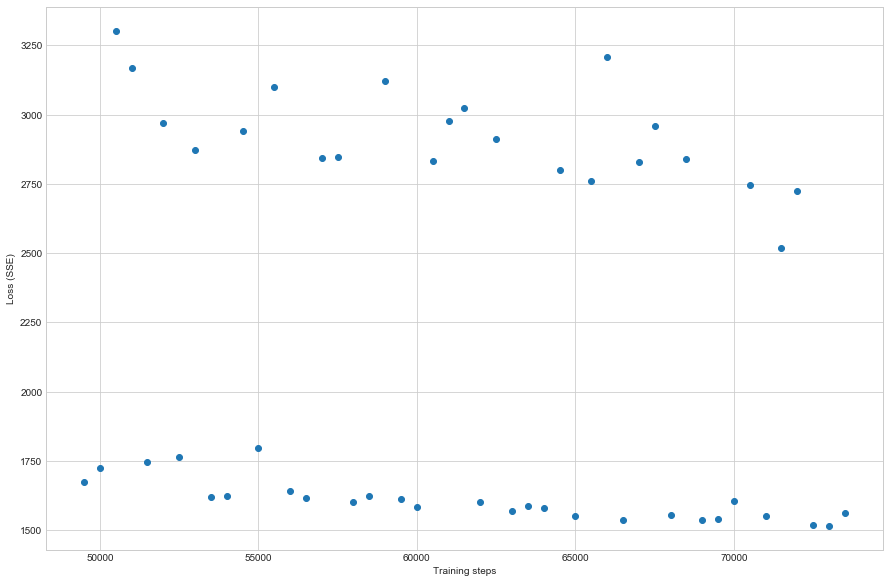

In [79]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [80]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-16/model.ckpt-73500


/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/dedeco/Envs/tensorflow/lib/python2.7/site-packages/

In [81]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f mm " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f mm" % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: -0.04
The Mean Absolute Error: 0.86 mm 
The Median Absolute Error: 0.63 mm


In [82]:
predictions

array([ 0.22439301,  5.204953  ,  0.37669098, ..., -0.31264007,
       -0.10936248,  0.36814606], dtype=float32)

In [83]:
predictions.size

12901

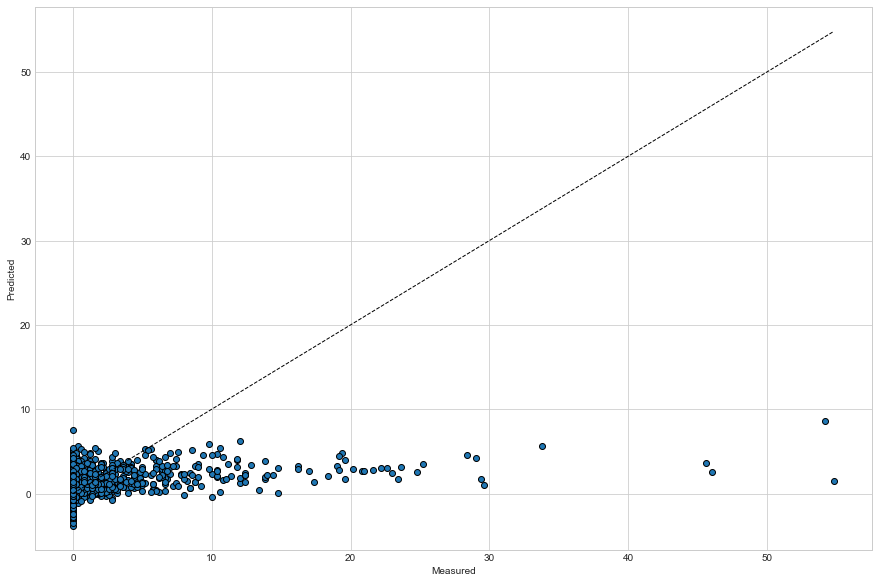

In [84]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()